In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class VGG16(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        
        self.block_1 =nn.Sequential(
                nn.Conv2d(in_channels=3,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),            
                nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),    
                nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))             
        )
            
        height, width = 3, 3
        self.classifier = nn.Sequential(
            nn.Linear(512*height*width, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
            
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()
                    
        self.avgpool = torch.nn.AdaptiveAvgPool2d((height, width))

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) 
        
        logits = self.classifier(x)

        return logits   
      

In [3]:
from matplotlib.patches import PathPatch
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, IterableDataset, DataLoader
from matplotlib import pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt


class FishDatasetLoader:
    def __init__(self, train_images_path) -> None:
        self.train_images_path = train_images_path

    def getData(self):
        print("creating loader...")
        valid_size = 0.2

        _transforms = transforms.Compose([
            transforms.Resize((224, 224)), 
            transforms.RandomEqualize(1),
            transforms.ToTensor(), 
            transforms.Normalize(
                mean=[0.5, 0.5, 0.5],
                std = [0.25, 0.25, 0.25]
            )

            ]) #resizes to square idk if good

        train_data = datasets.ImageFolder(self.train_images_path, transform=_transforms)
        test_data = datasets.ImageFolder(self.train_images_path, transform=_transforms)

        num_train = len(train_data)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))
        np.random.shuffle(indices)
        from torch.utils.data.sampler import SubsetRandomSampler
        train_idx, test_idx = indices[split:], indices[:split]
        
        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(test_idx)

        trainloader = torch.utils.data.DataLoader(train_data,
                    sampler=train_sampler, batch_size=64)
        testloader = torch.utils.data.DataLoader(test_data,
                    sampler=test_sampler, batch_size=64)

        return trainloader, testloader

    
    def getModel(self):
        print("creating model...")
        print(torch.cuda.is_available())
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        
        model = VGG16(8)


        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        for param in model.parameters():
            param.requires_grad = False

        for param in model.classifier.parameters():
            param.requires_grad = True
      

        model.to(device)
        return model, device, optimizer, criterion
    
    def trainModel(self, model, trainloader, testloader, device, optimizer, criterion):
        print("training...")

        epochs = 10
        steps = 0
        running_loss = 0
        print_every = 1 #changed from 100
        train_losses, test_losses, accuracies = [], [], []
        for epoch in range(epochs):
            for inputs, labels in trainloader:
                steps += 1

                #if steps==2:
                 # return train_losses, test_losses, accuracies

                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                logps = model.forward(inputs)
                loss = criterion(logps, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                if steps % print_every == 0:

                    test_loss = 0
                    accuracy = 0
                    model.eval()
                    with torch.no_grad():
                        for inputs, labels in testloader:
                            inputs, labels = inputs.to(device), labels.to(device)
                            logps = model.forward(inputs)
                            batch_loss = criterion(logps, labels)
                            test_loss += batch_loss.item()
                            
                            ps = torch.exp(logps)
                            top_p, top_class = ps.topk(1, dim=1)
                            equals = top_class == labels.view(*top_class.shape)
                            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                    train_losses.append(running_loss)
                    test_losses.append(test_loss/len(testloader))
                    accuracies.append(accuracy/len(testloader))                   
                    print(f"Epoch {epoch+1}/{epochs}.. "
                        f"Train loss: {running_loss:.3f}.. "
                        f"Test loss: {test_loss/len(testloader):.3f}.. "
                        f"Test accuracy: {accuracy/len(testloader):.3f}")
                    running_loss = 0
                    model.train()
              

        torch.save(model, 'aerialmodel.pth')
        return train_losses, test_losses, accuracies
    
    def check_work(self, train_losses, test_losses, accuracies):
        plt.figure(9)
        plt.plot(train_losses, label='Training loss')
        plt.plot(test_losses, label='Validation loss')

        plt.figure(10)
        plt.plot(accuracies, label='Accuracy')
        plt.show()
    
    def showImage(self, path, model, index):

      _transforms = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.RandomEqualize(1),
        transforms.ToTensor(), 
        transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std = [0.25, 0.25, 0.25]
        )

      ]) 
        
      img = Image.open(path)
      input = _transforms(img)

      plt.figure(index)
      plt.imshow(img)

      input = input.unsqueeze(0)
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      input = input.to(device)
      model.eval()
      output = model(input)
      print(output)


    def doWork(self):
        trainloader, testloader = self.getData()
        model, device, optimizer, criterion = self.getModel()
        train_losses, test_losses, accuracies = self.trainModel(model, trainloader, testloader, device, optimizer, criterion)

        
        self.showImage("/content/drive/MyDrive/fishes_input/train/ALB/img_00003.jpg",model,1)
        self.showImage("/content/drive/MyDrive/fishes_input/train/BET/img_00107.jpg",model,2)
        self.showImage("/content/drive/MyDrive/fishes_input/train/DOL/img_00165.jpg",model,3)
        self.showImage("/content/drive/MyDrive/fishes_input/train/LAG/img_00091.jpg",model,4)
        self.showImage("/content/drive/MyDrive/fishes_input/train/NoF/img_00008.jpg",model,5)
        self.showImage("/content/drive/MyDrive/fishes_input/train/OTHER/img_00063.jpg",model,6)
        self.showImage("/content/drive/MyDrive/fishes_input/train/SHARK/img_00033.jpg",model,7)
        self.showImage("/content/drive/MyDrive/fishes_input/train/YFT/img_00004.jpg",model,8)

        


        self.check_work(train_losses, test_losses, accuracies)

creating loader...
creating model...
True
training...
Epoch 1/10.. Train loss: 3.999.. Test loss: 7.051.. Test accuracy: 0.465
Epoch 1/10.. Train loss: 5.076.. Test loss: 2.490.. Test accuracy: 0.191
Epoch 1/10.. Train loss: 3.256.. Test loss: 5.112.. Test accuracy: 0.193
Epoch 1/10.. Train loss: 4.296.. Test loss: 3.101.. Test accuracy: 0.193
Epoch 1/10.. Train loss: 4.609.. Test loss: 1.848.. Test accuracy: 0.465
Epoch 1/10.. Train loss: 3.339.. Test loss: 1.935.. Test accuracy: 0.466
Epoch 1/10.. Train loss: 4.245.. Test loss: 1.906.. Test accuracy: 0.465
Epoch 1/10.. Train loss: 3.197.. Test loss: 1.777.. Test accuracy: 0.456
Epoch 1/10.. Train loss: 3.775.. Test loss: 1.762.. Test accuracy: 0.397
Epoch 1/10.. Train loss: 2.553.. Test loss: 1.942.. Test accuracy: 0.200
Epoch 1/10.. Train loss: 3.950.. Test loss: 1.861.. Test accuracy: 0.207
Epoch 1/10.. Train loss: 3.298.. Test loss: 1.615.. Test accuracy: 0.475
Epoch 1/10.. Train loss: 2.560.. Test loss: 1.711.. Test accuracy: 0.4

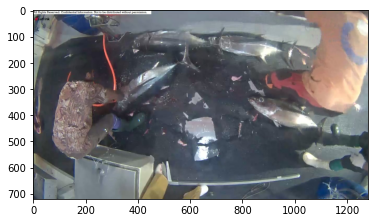

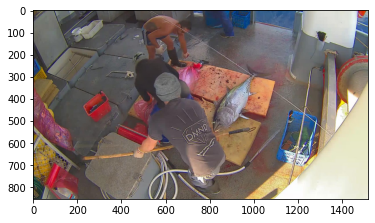

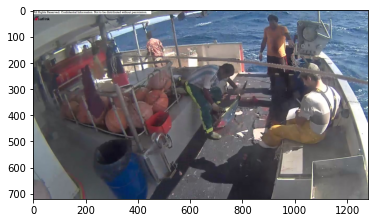

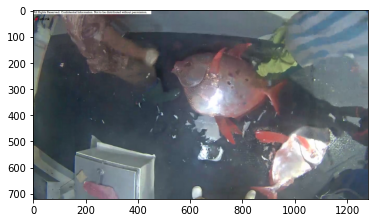

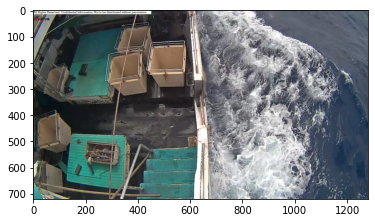

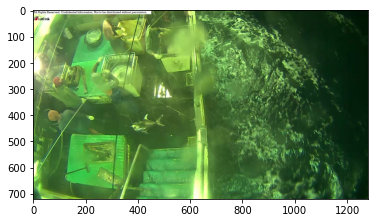

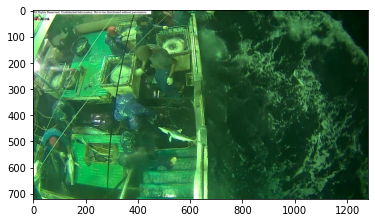

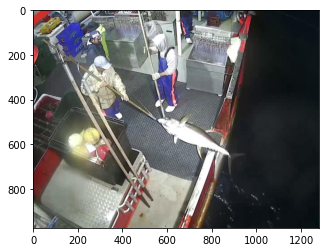

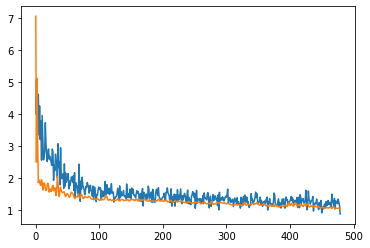

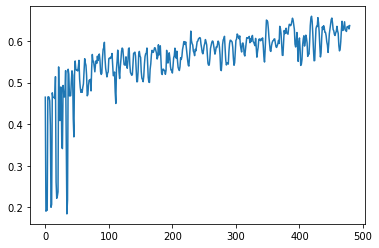

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor

def getMasterFolderPath():
    fileStream = open("/content/drive/MyDrive/path.txt", "r")
    return fileStream.read()

def dataUpload():
    master_folder_path = getMasterFolderPath()
    train_images_path = master_folder_path + "/train"

    fish_loader = FishDatasetLoader(train_images_path)
    fish_loader.doWork()


def main():
    torch.cuda.empty_cache()
    dataUpload()

main()